<a href="https://colab.research.google.com/github/Babatariq/MachineLearning-Siraj-/blob/master/lung_class_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
!pip install kaggle


In [0]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [0]:
from numpy.random import seed
from tensorflow import set_random_seed

In [0]:
os.environ['KAGGLE_USERNAME'] = "babatariq"
os.environ['KAGGLE_KEY'] = "bb26bd811560e2ae125aeda707adaeb8"

seed(100)
set_random_seed(100)

Here are the Helper functions 



In [0]:
def search_dir(type="normal", num=6):
  #Helper function to scan contents of directory
  counter=0

  for file in os.listdir(train_dir + type.upper()+ "/"):
      if counter == num:
          break

      if file.endswith(".jpeg"):
          print(file)

      counter += 1

In [0]:
def plot_images(type="normal", num=6):
  #Helper function to plot images
  counter=0
  fig = plt.figure(figsize=(10, 8))
  

  for file in os.listdir(train_dir + type.upper()):

      if file.endswith(".jpeg"):
          if counter == num:
              break

          img = mpimg.imread(train_dir + type.upper()+"/"+file)
          plt.subplot(231+counter)
          plt.title(file.split('.')[0])
          imgplot = plt.imshow(img)

          counter += 1

In [0]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

Data Downloading 



In [9]:
%time !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia #5 seconds

 99% 2.28G/2.29G [00:44<00:00, 35.1MB/s]
100% 2.29G/2.29G [00:44<00:00, 55.8MB/s]
CPU times: user 408 ms, sys: 79.7 ms, total: 488 ms
Wall time: 47.3 s


In [0]:
%time !unzip chest-xray-pneumonia.zip #10 seconds

In [0]:
os.remove("chest-xray-pneumonia.zip") # ZIP is now redundant

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [0]:
train_dir = "chest_xray/train/"
test_dir = "chest_xray/test/"
valid_dir = "chest_xray/val/"

In [15]:
search_dir(type = 'pneumonia', num = 10)

person1358_bacteria_3463.jpeg
person597_bacteria_2451.jpeg
person43_bacteria_216.jpeg
person1394_virus_2397.jpeg
person553_bacteria_2316.jpeg
person108_virus_199.jpeg
person543_bacteria_2281.jpeg
person1850_bacteria_4721.jpeg
person307_bacteria_1442.jpeg
person1403_bacteria_3559.jpeg


In [16]:
search_dir(type="normal", num=10)

NORMAL2-IM-1323-0001.jpeg
IM-0209-0001.jpeg
NORMAL2-IM-0645-0001.jpeg
NORMAL2-IM-0960-0001.jpeg
IM-0577-0001.jpeg
IM-0636-0001.jpeg
NORMAL2-IM-0417-0001.jpeg
NORMAL2-IM-1278-0001.jpeg
NORMAL2-IM-0727-0001.jpeg
NORMAL2-IM-1201-0001.jpeg


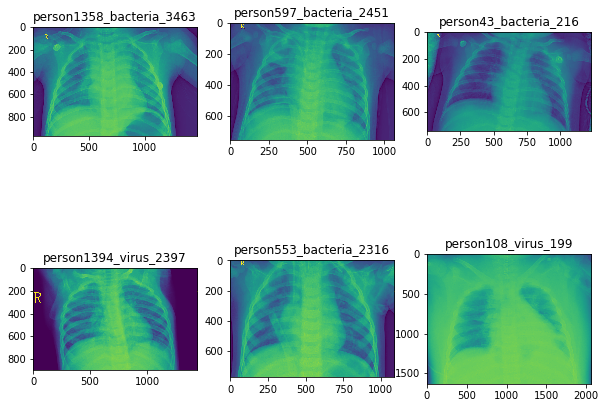

In [17]:
plot_images(type = 'pneumonia', num = 6) # show images of Xrays with pneumonia

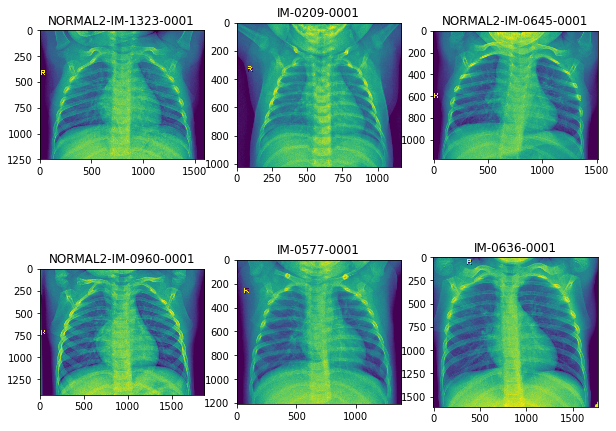

In [18]:
plot_images(type = 'normal', num = 6) # show images of Xrays with NO pnuemonia

Here we will build the model.

First step is to explore the models calssificatin prior to transfer learning training on our lung set


In [19]:
import numpy as np

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.python.keras.preprocessing import image

Using TensorFlow backend.


In [21]:
pre_model = InceptionV3( weights = 'imagenet')














96116736/96112376 [==============================] - 4s 0us/step


In [24]:
img = image.load_img( "/content/chest_xray/test/NORMAL/NORMAL2-IM-0007-001.jpeg", 
                     target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = pre_model.predict(x)
for index, res in enumerate(decode_predictions(y)[0]):
    print('{}. {}: {:.3f}%'.format(index + 1, res[1], 100 * res[2]))

40960/35363 [==================================] - 0s 0us/step
1. bathtub: 12.902%
2. scale: 10.562%
3. washer: 4.363%
4. conch: 4.145%
5. radiator: 3.223%


As you can see. This is very poor prediction!! So thats why we train the shallower layers of the IceptionV3

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
batch_size = 254 #should be a number 2^x


#Create training data generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1) #This primes the image generator to our specs

In [29]:
train_generator = train_datagen.flow_from_directory(
        train_dir, #directory that contains training data
        target_size=(150, 150), #what size image we want
        batch_size=batch_size, #how many files to read in at a time
        class_mode="categorical") 

Found 5216 images belonging to 2 classes.


In [31]:
#Create validation data generator

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
        valid_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode="categorical")

Found 16 images belonging to 2 classes.


In [32]:
#Create  test data generator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode="categorical",
        shuffle=False)

Found 624 images belonging to 2 classes.


Now its the fun part...Train the shallow model layers


In [33]:
import keras

base_model = InceptionV3(weights='imagenet', include_top=False) # so we can train the shallow layers

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)


for layer in base_model.layers:
  layer.trainable = False  # Stops depper layers from training 
  
final_model = keras.models.Model(inputs=base_model.inputs, outputs=predictions) #create final model

87916544/87910968 [==============================] - 3s 0us/step


In [34]:
final_model.compile(loss ="categorical_crossentropy", #another term for log loss
                    optimizer = "adam", 
                    metrics=["accuracy"])

In [35]:
fit_history = final_model.fit_generator(
        train_generator, #train data generator 
        steps_per_epoch=len(train_generator),
        epochs=5,
        validation_data= test_generator, #validation data generator 
        validation_steps=len(val_generator))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
21/21 [==============================] - 93s 4s/step - loss: 0.6414 - acc: 0.8084 - val_loss: 0.7602 - val_acc: 0.0000e+00
Epoch 2/5
21/21 [==============================] - 82s 4s/step - loss: 0.2638 - acc: 0.9044 - val_loss: 3.1095e-04 - val_acc: 1.0000
Epoch 3/5
21/21 [==============================] - 84s 4s/step - loss: 0.2415 - acc: 0.9082 - val_loss: 3.5763e-07 - val_acc: 1.0000
Epoch 4/5
21/21 [==============================] - 85s 4s/step - loss: 0.2244 - acc: 0.9108 - val_loss: 0.5973 - val_acc: 1.0000
Epoch 5/5
21/21 [==============================] - 84s 4s/step - loss: 0.2128 - acc: 0.9145 - val_loss: 3.6240e-05 - val_acc: 1.0000


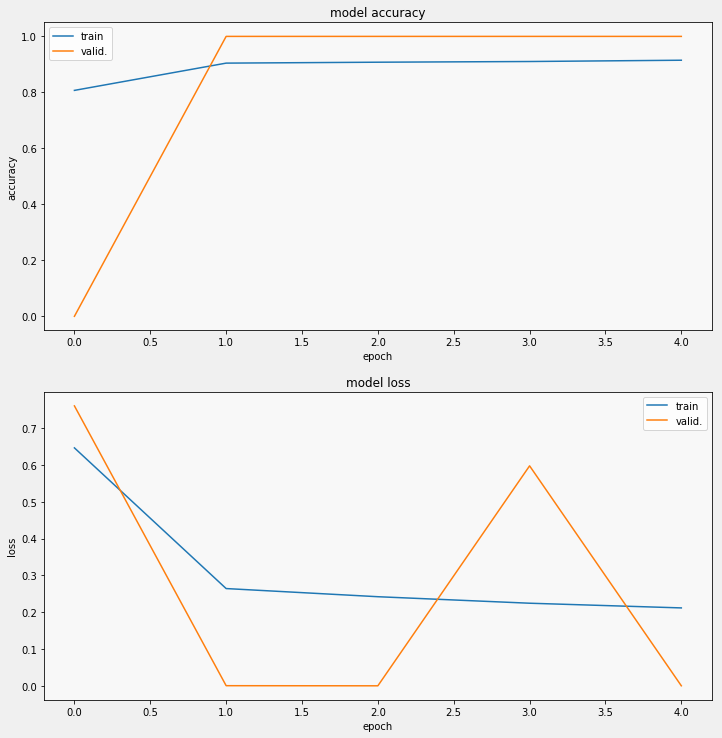

In [36]:
display_training_curves(fit_history.history['acc'], fit_history.history['val_acc'], 'accuracy', 211)
display_training_curves(fit_history.history['loss'], fit_history.history['val_loss'], 'loss', 212)

In [37]:
result  = final_model.evaluate_generator(test_generator,steps=len(test_generator))
print('Loss:', result[0])
print('Accuracy:', result[1])

Loss: 1.091417810555363
Accuracy: 0.75


Mediocre result. Could be improved with Regularization / dropouts etc or modify optimizer and loss funtion

In [38]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [39]:
#Generate all predictions
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = final_model.predict_generator(test_generator,steps = nb_samples).argmax(axis=-1)

predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,

In [40]:
#Generate true labels
test_generator.classes 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

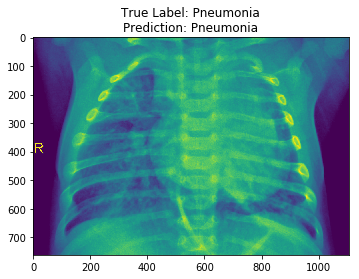

In [43]:
#@title Enter Filepath Here:
filename = "/content/chest_xray/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg" #@param {type:"string"}

img = image.load_img(filename, 
                     target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = final_model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)